# **🌦️ Kaggle Playground: Rainfall Prediction**
## **A Machine Learning Approach**
---
📌 **Author:** Juan Manuel Arias 
📌 **Objective:** Predict daily rainfall probability using machine learning.  
📌 **Dataset:** Kaggle Playground Series (March 2025).  
📌 **Evaluation Metric:** ROC AUC (Area Under the Curve).  
📌 **Best Model:** CatBoostClassifier.  

---
### **📖 Overview**
In this notebook, we will develop a machine learning model to predict whether it will rain based on weather conditions. The dataset includes features such as **temperature, humidity, wind speed, cloud coverage, and atmospheric pressure**.

---
## **📥 1. Importing Libraries**

In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")  # Aesthetic plots


## **📊 2. Loading the Dataset**
We will load both the training and test datasets and inspect their structure.


In [8]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Display dataset structure
print(f"Training Data Shape: {train.shape}")
print(f"Test Data Shape: {test.shape}")
print(f"Columns: {train.columns.tolist()}")

# Preview first few rows
train.head()


Training Data Shape: (2190, 13)
Test Data Shape: (730, 12)
Columns: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall']


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


---

## **🔍 3. Exploratory Data Analysis (EDA)**
Before building the model, let's analyze the data. We will:
- Check class distribution.
- Visualize correlations between features.


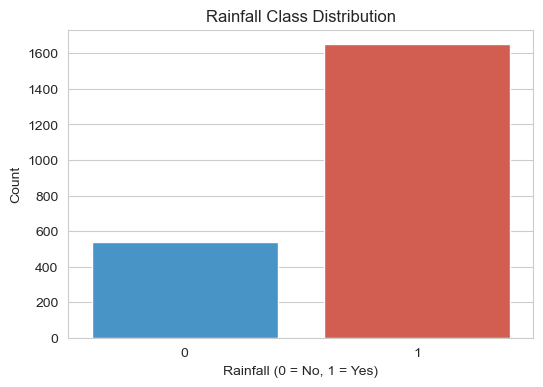

In [10]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=train['rainfall'], palette=['#3498db', '#e74c3c'])
plt.title("Rainfall Class Distribution")
plt.xlabel("Rainfall (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


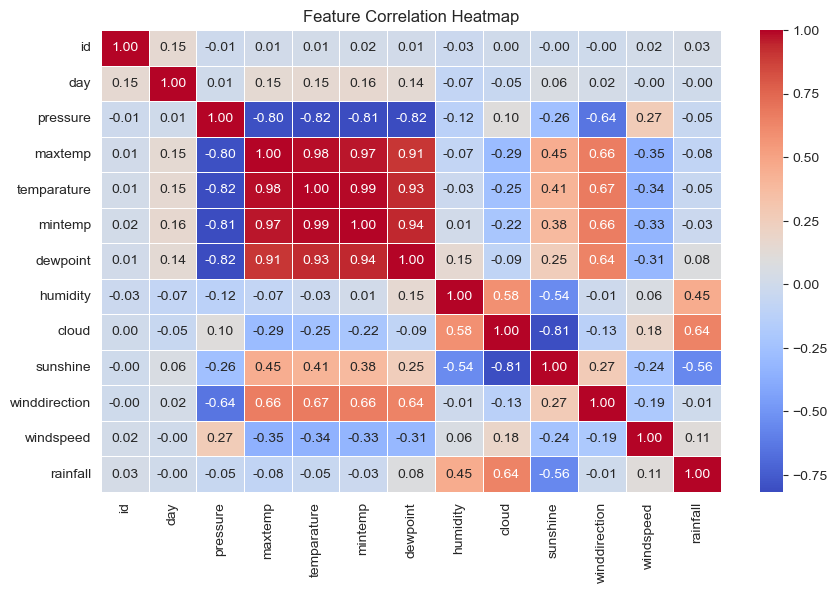

In [11]:
# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


## **🛠️ 4. Feature Engineering**
To enhance model performance, we create additional features:
✅ Temperature range (max - min).  
✅ Seasonal encoding (sin & cos of day).  
✅ Wind direction transformation (sin & cos).  
✅ Humidity-to-dewpoint ratio.  
✅ Additional interactions (cloud/sunshine, wind-temperature).  


In [13]:
def feature_engineering(df):
    """Apply feature transformations to improve model performance."""
    df['temp_range'] = df['maxtemp'] - df['mintemp']
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365)
    df['wind_dir_sin'] = np.sin(2 * np.pi * df['winddirection'] / 360)
    df['wind_dir_cos'] = np.cos(2 * np.pi * df['winddirection'] / 360)
    df['humidity_dewpoint_ratio'] = df['humidity'] / (df['dewpoint'] + 1e-5)

    # Additional interactions
    df['temp_mid'] = (df['maxtemp'] + df['mintemp']) / 2
    df['dew_temp_diff'] = df['temparature'] - df['dewpoint']
    df['cloud_sunshine_ratio'] = df['cloud'] / (df['sunshine'] + 1e-5)
    df['wind_temp_interaction'] = df['windspeed'] * df['temparature']
    
    return df

# Apply feature engineering
train = feature_engineering(train)
test = feature_engineering(test)


## **📌 5. Handling Missing Values**
Since missing values can affect model performance, we will **impute missing values** using the median strategy.


In [15]:
# Prepare features for training
features_train = train.drop(['id', 'rainfall'], axis=1)
features_test = test.drop(['id'], axis=1)

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(features_train), columns=features_train.columns)
X_test = pd.DataFrame(imputer.transform(features_test), columns=features_test.columns)
y = train['rainfall']

print(f"Processed Training Data Shape: {X.shape}")


Processed Training Data Shape: (2190, 21)


## **🤖 6. Training the Best Model**
After testing multiple models, **CatBoostClassifier** performed the best.  
🚀 **Why CatBoost?**
- Handles categorical and numerical features efficiently.
- Requires less preprocessing.
- Robust to missing values.


In [17]:
# Train the best model
best_cat = CatBoostClassifier(random_state=42, verbose=0, iterations=300, depth=5, learning_rate=0.01)
best_cat.fit(X, y)


## **📈 7. Model Evaluation**
We evaluate model performance using **ROC AUC** (Area Under the Curve).  
This metric is ideal for binary classification as it measures the ability of the model to distinguish between classes.


Training ROC AUC: 0.9217


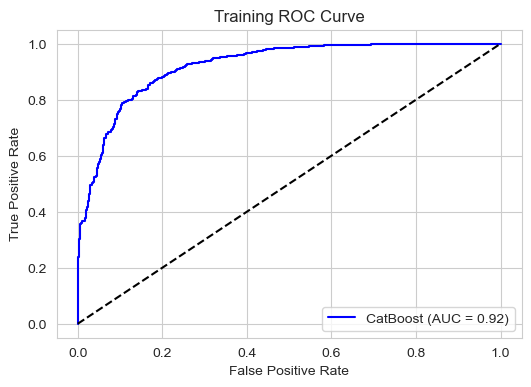

In [19]:
# Model evaluation
y_pred = best_cat.predict_proba(X)[:, 1]
train_auc = roc_auc_score(y, y_pred)
print(f"Training ROC AUC: {train_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y, y_pred)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {train_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve')
plt.legend(loc='lower right')
plt.show()


## **📤 8. Generating Predictions for Submission**
Finally, we generate predictions for the test set and create a submission file.


In [21]:
# Generate test predictions
test_pred = best_cat.predict_proba(X_test)[:, 1]
submission = pd.DataFrame({'id': test['id'], 'rainfall': test_pred})
submission.to_csv('submission_best_model.csv', index=False)

print("✅ Submission file 'submission_best_model.csv' created successfully!")


✅ Submission file 'submission_best_model.csv' created successfully!


# **🎯 Final Thoughts**
✅ We explored the dataset and performed **EDA**.  
✅ We engineered **new features** to improve performance.  
✅ We trained and evaluated **CatBoostClassifier**, which outperformed other models.  
✅ We generated predictions and created a **Kaggle submission** file.  
